# imports

In [1]:
import datetime
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply as rolling_apply_ext
import talib
from talib import MA_Type
import numpy.linalg

In [5]:
date_str_20220901 = "2022-09-01"
date_str_20220919 = "2022-09-19"
date_str_20220920 = "2022-09-20"
date_str_20220921 = "2022-09-21"
date_str_20220922 = "2022-09-22"
date_str_20220923 = "2022-09-23"
date_str_20220924 = "2022-09-24"
date_str_20220925 = "2022-09-25"
date_str_20220930 = "2022-09-30"

date_str_20230801 = "2023-08-01"
date_str_20230803 = "2023-08-03"
date_str_20230806 = "2023-08-06"
date_str_20230809 = "2023-08-09"
date_str_20230831 = "2023-08-31"

In [6]:
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-26T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close')

In [7]:
df_202209 = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-01T04:00:00Z_2022-09-30T03:59:00Z.csv')
df_202209['time'] = pd.to_datetime(df_202209['timestamp'], unit='s')
df_close_202209 = df_202209.pivot(index='time', columns='symbol', values='close')

In [9]:
df_202308 = pd.read_csv('market_data_binance.by_minute_ALL_2023-08-01T04:00:00Z_2023-08-31T03:59:00Z.csv')
df_202308['time'] = pd.to_datetime(df_202308['timestamp'], unit='s')
df_close_202308 = df_202308.pivot(index='time', columns='symbol', values='close')
df_close_20230806_20230809 = df_close_202308[(df_close_202308.index >= date_str_20230806) & (df_close_202308.index < date_str_20230809)]

In [10]:
def get_close_between_datetime(sample_period_minutes, symbols, start_datetime_str, end_datetime_str):  
    df = df_close_202308 # df_close
    return df[(df.index >= start_datetime_str) & (df.index < end_datetime_str)][symbols].resample(f'{sample_period_minutes}min').last()

def get_close_between_date(sample_period_minutes, symbols, start_date_str, end_date_str):   
    return get_close_between_datetime(sample_period_minutes, symbols, start_date_str + " 00:00:000", end_date_str + " 00:00:000")

In [12]:
def get_high_corr_symbols(start_symbol, num, candidate_symbols):
    df_corr = df_close_202308[(df_close_202308.index >= date_str_20230806) & (df_close_202308.index < date_str_20230809)].resample(f'10min').last().corr()

    def best_corr(sym, symbols):
        corrs = []
        for symbol_col in symbols:
            if sym == symbol_col: break
            corrs.append((df_corr.loc[sym][symbol_col], sym, symbol_col,))
        
        best_corr = sorted(corrs, reverse=True)[0]
        print(f'{best_corr}')
        return best_corr[2]

    ret = [start_symbol]
    symbols = [s for s in candidate_symbols if s != start_symbol]
    symbol_base = start_symbol
    for _ in range(num-1):
        symbols = [s for s in symbols if s != symbol_base]
        symbol = best_corr(symbol_base, symbols)
        ret.append(symbol)
        symbol_base = symbol

    return ret

In [13]:
def get_high_corr_symbols_set_of(set_size, set_num, candidate_symbols):
    df_corr = df_close_202308[(df_close_202308.index >= date_str_20230806) & (df_close_202308.index < date_str_20230809)].resample(f'10min').last().corr()

    def find_start_symbol(symbols_pool):
        corrs = []
        for symbol_row in symbols_pool:
            for symbol_col in symbols_pool:
                if symbol_row == symbol_col: break
                corrs.append((df_corr.loc[symbol_row][symbol_col], symbol_row, symbol_col,))

        corrs = sorted(corrs, reverse=True)
        start_symbol = corrs[0][1]
        return start_symbol

    start_symbol = find_start_symbol(candidate_symbols)
    ret = []
    symbols_pool = [s for s in candidate_symbols if s != start_symbol]
    for _ in range(set_num):
        print(f'start_symbol: {start_symbol}')
        symbols = get_high_corr_symbols(start_symbol, set_size, symbols_pool)
        ret.append(symbols)

        symbols_pool = [s for s in symbols_pool if s not in symbols]
        start_symbol = find_start_symbol(symbols_pool)
        symbols_pool = [s for s in symbols_pool if s != start_symbol]
    return ret

In [14]:
df_close_20230806_20230809.mean()

symbol
1INCHBUSD     0.305727
1INCHUSDT     0.305988
AAVEBUSD     65.037268
AAVEUSDT     65.100026
ACABUSD       0.060199
               ...    
ZENUSDT       9.426237
ZILBUSD       0.020417
ZILUSDT       0.020434
ZRXBUSD       0.219767
ZRXUSDT       0.219990
Length: 648, dtype: float64

In [15]:
symbols_pool = [s for _, s in sorted([(m, s) for s, m in df_close_20230806_20230809.mean().items() if m > 50], reverse=True)]
# remove duplicates within USDT / BUSD swap
symbols_pool = [s for s in symbols_pool if s not in [s.replace('USDT', 'BUSD') for s in symbols_pool if 'USDT' in s]]
symbols_pool

['BTCUSDT',
 'WBTCUSDT',
 'YFIUSDT',
 'PAXGUSDT',
 'WBETHUSDT',
 'ETHUSDT',
 'BETHUSDT',
 'MKRUSDT',
 'YFIIUSDT',
 'BIFIUSDT',
 'BNBUSDT',
 'BCHUSDT',
 'XMRUSDT',
 'GNOUSDT',
 'QNTUSDT',
 'LTCUSDT',
 'AAVEUSDT',
 'COMPUSDT',
 'KP3RUSDT',
 'GMXUSDT']

In [16]:
symbols_sets = get_high_corr_symbols_set_of(3, 4, symbols_pool)
symbols_sets

start_symbol: BETHUSDT
(0.9172113644568137, 'BETHUSDT', 'ETHUSDT')
(0.6127688647366215, 'ETHUSDT', 'YFIIUSDT')
start_symbol: BIFIUSDT
(0.8893106589315448, 'BIFIUSDT', 'YFIUSDT')
(0.8596186418471401, 'YFIUSDT', 'KP3RUSDT')
start_symbol: AAVEUSDT
(0.822628051832634, 'AAVEUSDT', 'BCHUSDT')
(0.6877538575134322, 'BCHUSDT', 'BNBUSDT')
start_symbol: GMXUSDT
(0.7090807837081147, 'GMXUSDT', 'BTCUSDT')
(0.5397576519955705, 'BTCUSDT', 'MKRUSDT')


[['BETHUSDT', 'ETHUSDT', 'YFIIUSDT'],
 ['BIFIUSDT', 'YFIUSDT', 'KP3RUSDT'],
 ['AAVEUSDT', 'BCHUSDT', 'BNBUSDT'],
 ['GMXUSDT', 'BTCUSDT', 'MKRUSDT']]

In [39]:
#symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
#symbols = ['YFIIUSDT', 'ETHUSDT', 'BIFIUSDT']
symbols = ['GMXUSDT', 'BTCUSDT', 'MKRUSDT']

In [40]:
get_close_between_date(10, symbols, date_str_20230806, date_str_20230809).dropna().head()

symbol,GMXUSDT,BTCUSDT,MKRUSDT
time,,,
2023-08-06 02:50:00,53.62,29068.59,1251.0
2023-08-06 03:10:00,53.55,29057.99,1244.0
2023-08-06 03:20:00,53.63,29056.98,1240.0
2023-08-06 03:30:00,53.51,29061.26,1236.0
2023-08-06 03:40:00,53.55,29059.05,1237.0


<Axes: xlabel='time'>

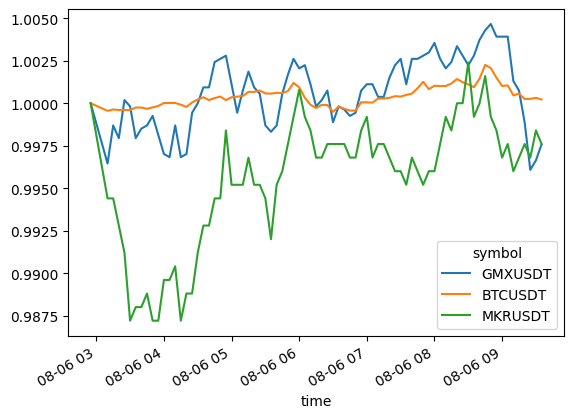

In [41]:
df = get_close_between_date(5, symbols, date_str_20230806, date_str_20230809).dropna()
(df / df.iloc[0]).plot()

In [42]:
df = get_close_between_date(5, symbols, date_str_20230806, date_str_20230809).dropna()
(df / df.iloc[0])

symbol,GMXUSDT,BTCUSDT,MKRUSDT
time,,,
2023-08-06 02:55:00,1.000000,1.000000,1.000000
2023-08-06 03:10:00,0.996457,0.999553,0.994404
2023-08-06 03:15:00,0.998695,0.999635,0.994404
2023-08-06 03:20:00,0.997949,0.999600,0.992806
2023-08-06 03:25:00,1.000186,0.999601,0.991207
...,...,...,...
2023-08-06 09:15:00,1.000746,1.000560,0.996803
2023-08-06 09:20:00,0.998881,1.000255,0.997602
2023-08-06 09:25:00,0.996084,1.000255,0.996803


In [46]:
get_close_between_date(10, symbols, date_str_20230806, date_str_20230809).corr().style.background_gradient(cmap='coolwarm')

symbol,GMXUSDT,BTCUSDT,MKRUSDT
symbol,,,
GMXUSDT,1.000000,0.709081,0.638756
BTCUSDT,0.709081,1.000000,0.539758
MKRUSDT,0.638756,0.539758,1.000000


In [47]:
get_close_between_date(1, symbols, date_str_20230806, date_str_20230809).corr().style.background_gradient(cmap='coolwarm')

symbol,GMXUSDT,BTCUSDT,MKRUSDT
symbol,,,
GMXUSDT,1.000000,0.729625,0.616384
BTCUSDT,0.729625,1.000000,0.551716
MKRUSDT,0.616384,0.551716,1.000000


In [49]:
get_close_between_date(10, symbols, date_str_20230806, date_str_20230831).corr().style.background_gradient(cmap='coolwarm')

symbol,GMXUSDT,BTCUSDT,MKRUSDT
symbol,,,
GMXUSDT,1.000000,0.910819,0.924571
BTCUSDT,0.910819,1.000000,0.898876
MKRUSDT,0.924571,0.898876,1.000000


In [50]:
get_close_between_date(1, symbols, date_str_20230806, date_str_20230831).corr().style.background_gradient(cmap='coolwarm')

symbol,GMXUSDT,BTCUSDT,MKRUSDT
symbol,,,
GMXUSDT,1.000000,0.911416,0.924855
BTCUSDT,0.911416,1.000000,0.898721
MKRUSDT,0.924855,0.898721,1.000000


# Sanity check: eigen values, vectors

In [674]:
mat = [[1, 2, 0], [2, 1, 0], [0, 0, 4]]
eiven_vals, eigen_vecs = np.linalg.eig(mat)

In [8]:
eiven_vals

array([ 3., -1.,  4.])

In [9]:
eigen_vecs

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [10]:
eigen_vecs[:,0]

array([0.70710678, 0.70710678, 0.        ])

note that the matrix represenation is bit confusing. v[i,:] is *not* eigenvector, but v[:,i] is. So below is *not* an eigen vector.

In [11]:
eigen_vecs[0]

array([ 0.70710678, -0.70710678,  0.        ])

and accordingly the eigenvalues matix on the rhs is to be horizontally layed down.

In [12]:
eigen_vecs @ np.diag(eiven_vals) @ eigen_vecs.T

array([[1., 2., 0.],
       [2., 1., 0.],
       [0., 0., 4.]])

In [13]:
mat @ eigen_vecs[:,0]

array([2.12132034, 2.12132034, 0.        ])

# Solve the minimal predictability condition

the eigen_vecs are for calculation only, the actual distribution over the asset is returned in `wgts`.

In [25]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    arr_lead = arr[lag:]
    arr_lag = arr[:m-lag]
    return 1.0 / (m - lag - 1) * (arr_lead - np.nanmean(arr_lead, axis=0)).T @ (arr_lag - np.nanmean(arr_lag, axis=0))

In [26]:
def get_var1_wgts_values_transpose(*df_values_T):
    cov = np.cov(df_values_T)
    cov_inv = np.linalg.inv(cov)
    cov_inv_sqrt = scipy.linalg.sqrtm(cov_inv)
    autocov = calc_autocov_matrix(np.transpose(df_values_T), 1)
    #var_predictability = cov_inv_sqrt @ autocov @ cov @ autocov.T @ cov_inv_sqrt.T
    var_predictability = cov_inv_sqrt @ autocov @ cov_inv @ autocov.T @ cov_inv_sqrt.T

    var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability)

    asc = np.argsort(var_eigen_vals)
    var_eigen_vals, var_eigen_vecs = var_eigen_vals[asc], var_eigen_vecs[:, asc]
    wgts = cov_inv_sqrt @ var_eigen_vecs
    if np.sign((np.transpose(df_values_T) @ wgts[:,0])[-1]) < 0:
        pass # var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1

    # allign the sign of the last element of the first eigen vector.
    if np.sign(wgts[-1,0]) < 0:
        var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1

    # allign the sign of the constructed portfolio
    if np.sign((np.transpose(df_values_T) @ wgts[:,0])[0]) < 0:
        var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1

    return var_eigen_vals, var_eigen_vecs, wgts

In [27]:
def get_var1_wgts(df):
    return get_var1_wgts_values_transpose(*df.values.T)

The same function that takes df.values.T instead of df itself. This is used in the custom rolling function as the custom rolling function does not take the data frame but the arrays.

# Trading calculations

In [28]:
def bband(values, window, stds):
    df_band = values.copy()
    df_band['upper'] = (values.ewm(alpha=0.1).mean() + stds * values.rolling(window).std()) # * values.rolling(window).apply(adjustment_factor))
    df_band['lower'] = (values.ewm(alpha=0.1).mean() - stds * values.rolling(window).std()) # / values.rolling(window).apply(adjustment_factor))
    return df_band   

In [29]:
class TradingParam:
    def __init__(self, bb_windows, bb_stdev):
        self.bb_windows, self.bb_stdev = bb_windows, bb_stdev

def add_features(df_prices, wgt, trading_param):
    df_prices_weighted = df_prices * wgt
    values = df_prices_weighted.sum(axis=1).to_frame().rename(columns={0: 'value'})

    # rebalance
    if type(wgt) is np.ndarray or type(wgt) is pd.core.series.Series:
        values['rebalanced'] = 0
    else:
        values['rebalanced'] = wgt.sum(axis=1).to_frame().diff().fillna(0)
    values = values.fillna(0)
    values['rebalanced'] = values[['rebalanced']].where(values.rebalanced == 0, 1)

    rebalance_ages = [1]
    for i in range(1, len(values.index)):
        rebalance_age = rebalance_ages[-1] + 1
        if values.rebalanced.values[i] > 0:
            rebalance_age = 1
        rebalance_ages.append(rebalance_age)
    values['rebalance_age'] = rebalance_ages

    # bband and crossing
    '''
    upper, middle, lower = talib.BBANDS(values.value, trading_param.bb_windows, trading_param.bb_stdev, matype=MA_Type.T3)
    '''
    df_band = bband(values.value, trading_param.bb_windows, trading_param.bb_stdev)
    upper, lower = df_band.upper, df_band.lower

    values['upper'] = upper
    values['lower'] = lower 
    #upper, middle, lower, values = upper.dropna(), middle.dropna(), lower.dropna(), values.dropna()
    
    values['value_prev'] = values.value.shift()
    values['lower_crossed_upward'] = ((values.value_prev <= lower.shift()) & (values.value >= lower)).astype(np.int32)
    values['lower_crossed_downward'] = ((values.value_prev >= lower.shift()) & (values.value <= lower)).astype(np.int32)
    values['upper_crossed_upward'] = ((values.value_prev <= upper.shift()) & (values.value >= upper)).astype(np.int32)
    values['upper_crossed_downward'] = ((values.value_prev >= upper.shift()) & (values.value <= upper)).astype(np.int32)
    values = values.dropna()

    # in/out position with bband
    in_positions = [0]
    for i in range(1, len(values.index)):
        in_position = in_positions[-1]
        # if i_decision = i-1, the position of current is one step delayed to make it more realistic.
        # on the other hand, it might be too unrealistically strigent condition
        decision_delay = 0
        i_decision = i - decision_delay
        if values.lower_crossed_upward.values[i_decision] > 0: in_position = 1
        #elif values.upper_crossed_upward.values[i_decision] > 0: in_position = 1
        elif values.upper_crossed_downward.values[i_decision] > 0: in_position = 0
        #elif values.lower_crossed_downward.values[i_decision] > 0: in_position = 0
        in_positions.append(in_position)
    values['in_position'] = in_positions
    values['position_changed'] = values.in_position.diff()

    # position size
    df_prices_weighted['pos_mean_size'] = df_prices_weighted.where(df_prices_weighted > 0).mean(1)
    df_prices_weighted['neg_mean_size'] = -df_prices_weighted.where(df_prices_weighted <= 0).mean(1)
    df_prices_weighted['mean_size'] = df_prices_weighted[['pos_mean_size', 'neg_mean_size']].mean(1)
    values['mean_size'] = df_prices_weighted['mean_size']

    position_sizes = [0]
    for i in range(1, len(values.index)):
        position_size = position_sizes[-1]
        # the position of current is one step delayed to make it more realistic.
        if values.position_changed.values[i-1] > 0:
            position_size = values.mean_size.values[i]
        if values.position_changed.values[i-1] < 0:
            position_size = 0
        position_sizes.append(position_size)
    values['position_size'] = position_sizes

    # pnl
    # the result of position of current cycle gets reflected in the next cycle to prevent look-ahead bias.
    values['profit_raw'] = values.value.diff() * values.in_position.shift()
    values['profit'] = values.value.pct_change() * values.in_position.shift()

    return values

# Static Portfolio construction

In [24]:
#df_prices = get_close_between_date(10, symbols, date_str_20220919, date_str_20220922)
df_prices = get_close_between_date(1, symbols, date_str_20220919, date_str_20220922)
var_eigen_vals, var_eigen_vecs, wgts = get_var1_wgts_values_transpose(*df_prices.values.T)

In [25]:
var_eigen_vals

array([0.94074868, 0.97783309, 0.99276419])

In [26]:
print(var_eigen_vecs[:,0])
print(wgts[:,0])

[-0.38076875 -0.08217091  0.921012  ]
[-0.06350456 -0.02646201  0.38747263]


In [27]:
print(var_eigen_vecs[:,-1])
print(wgts[:,-1])

[0.44267965 0.85828222 0.25958881]
[0.01346659 0.02183511 0.06154249]


In [28]:
get_close_between_date(10, symbols, date_str_20220919, date_str_20220921).head(3)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-19 04:00:00,834.2,1300.92,340.1
2022-09-19 04:10:00,834.6,1303.61,340.1
2022-09-19 04:20:00,835.4,1303.85,343.0


## Graphs

<Axes: xlabel='time'>

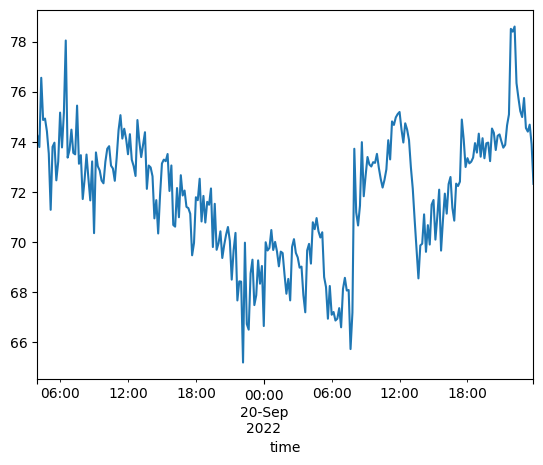

In [877]:
(get_close_between_date(10, symbols, date_str_20220919, date_str_20220921) * var_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

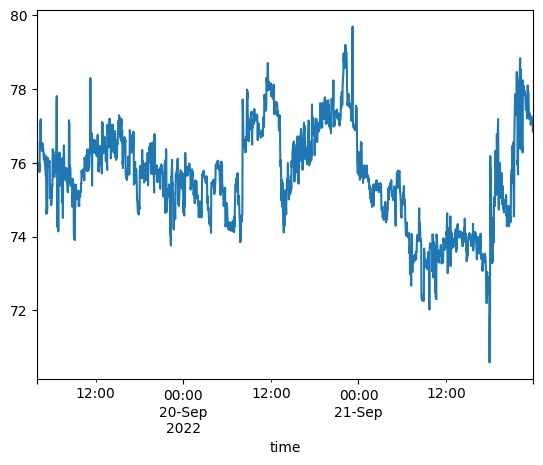

In [878]:
(get_close_between_date(2, symbols, date_str_20220919, date_str_20220922) * wgts[:,0]).sum(axis=1).plot()

## Bollinger bands trading

In [29]:
trading_param = TradingParam(60, 2.0)
values = add_features(df_prices, wgts[:,0], trading_param)

<Axes: xlabel='time'>

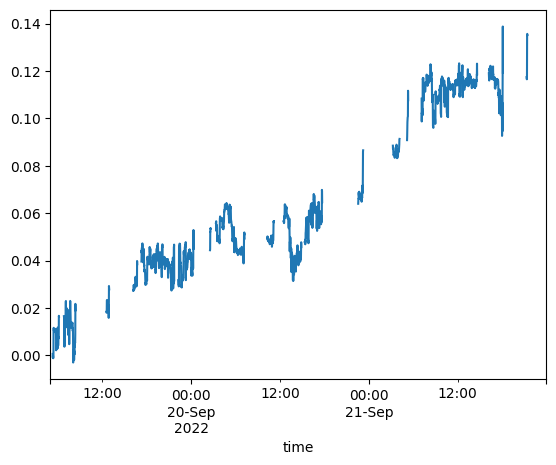

In [30]:
(values.profit_raw / values.position_size).cumsum().plot()

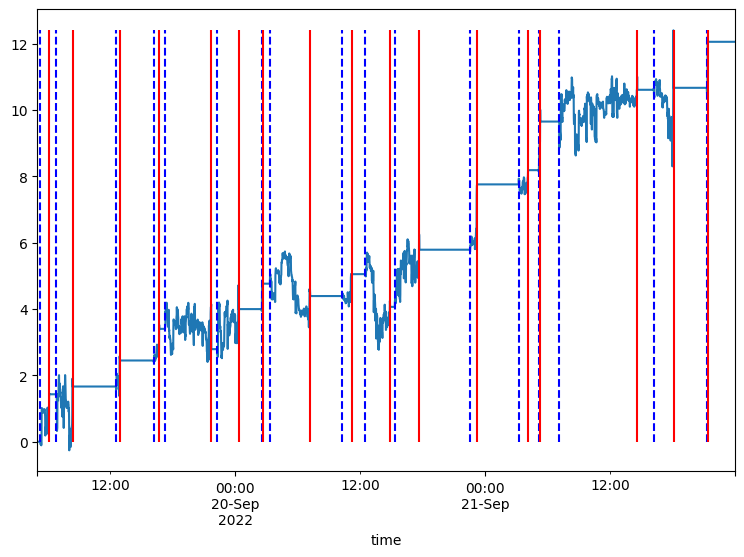

In [31]:
ax = values.profit_raw.cumsum().iloc[:,].plot(figsize=(9, 6))
ymin, ymax = 0, values.profit_raw.cumsum().max()

# add vertical lines
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

<Axes: xlabel='time'>

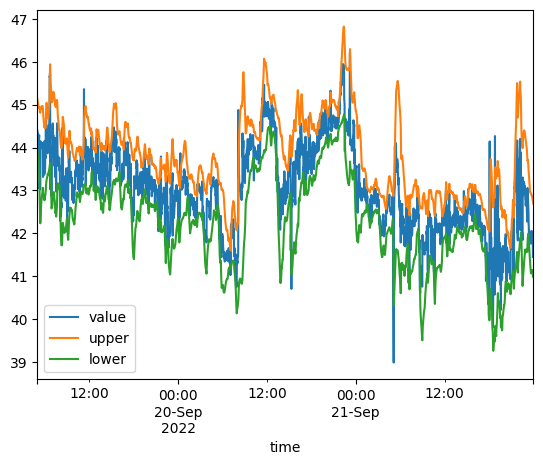

In [32]:
values[['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

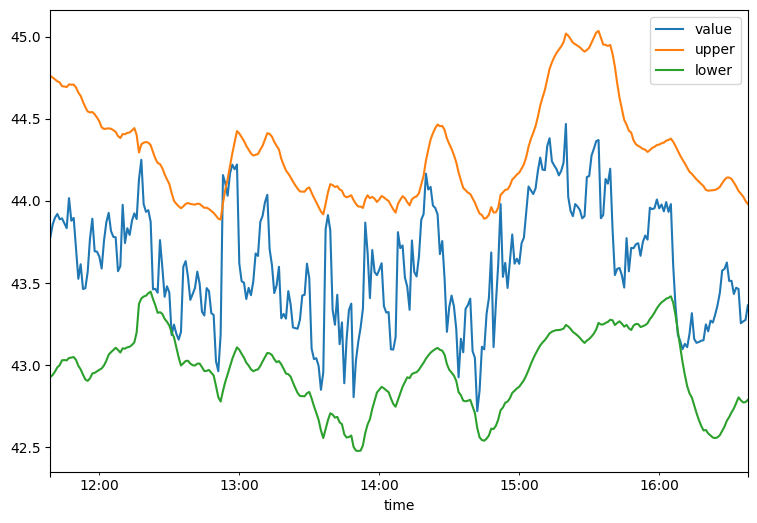

In [33]:
values[['value', 'upper', 'lower']].dropna().iloc[400:700,].plot(figsize=(9, 6))

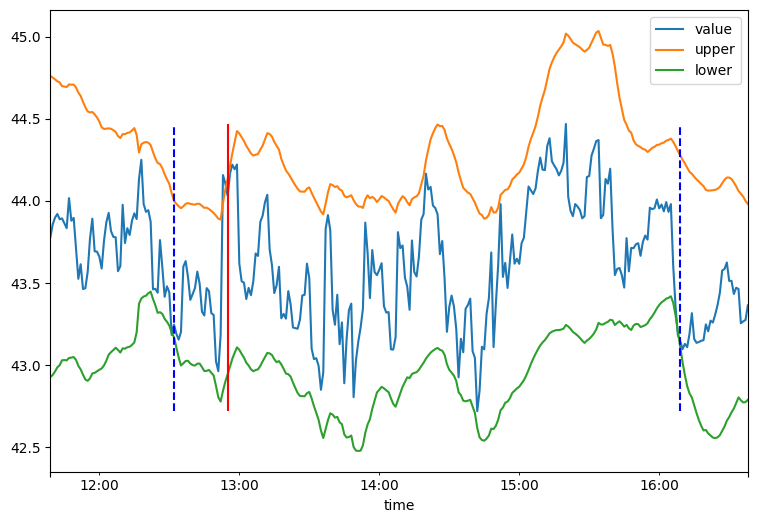

In [34]:
ax = values[['value', 'upper', 'lower']].dropna().iloc[400:700,].plot(figsize=(9, 6))
ymin, ymax = values.iloc[400:700,].value.min(), values.iloc[400:700,].value.max()

# add vertical lines
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

NameError: name 'values_rolling' is not defined

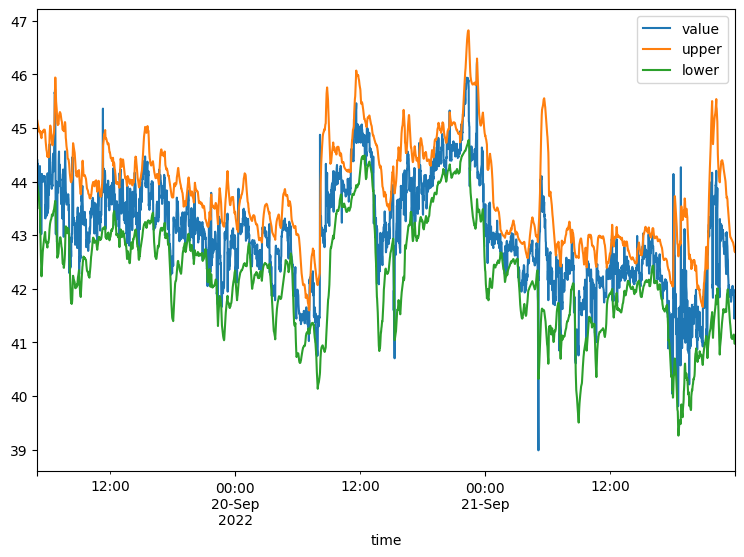

In [35]:
# plot dataframe; the index is a datetime index
ax = values[['value', 'upper', 'lower']].dropna().plot(figsize=(9, 6))
ymin, ymax = values.value.min(), values.value.max()

# add vertical lines
ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

# Rolling-based Portfolio Construction

In [30]:
def get_var1_wgts_values_transpose_rolling(df_prices, window, rebalance_period, sample_unit_minutes, order, if_evecs):
    '''
    order: 0 for the smallest eigen value, -1 for the largest.
    if_evecs: True for eigen vectors, False for weights (e-vecs / sqrt(cov))
    '''
    i = 1 if if_evecs else 2
    rolling_wgt = rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[i][:,order], window, *df_prices.values.T)
    df_rolling_wgt = pd.DataFrame(rolling_wgt, index=df_prices.index, columns=df_prices.columns)
    # shift by one time unit as the weight up to now will practically be applied in the next step. (?)
    df_rolling_wgt = df_rolling_wgt.shift()
    #df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{rebalance_period * sample_unit_minutes}min').first().resample(f'{sample_unit_minutes}min').first().ffill()
    df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{rebalance_period * sample_unit_minutes}min').first()
    return df_rolling_wgt, df_rolling_wgt_resampled

In [31]:
def get_trading_result(symbols, trading_param):
    fitting_window, rebalance_period = 180, 180
    #df_prices = get_close_between_date(1, symbols, date_str_20220919, date_str_20220922)
    df_prices = get_close_between_date(1, symbols, date_str_20230801, date_str_20230831).dropna()
    df_rolling_evecs, df_rolling_evecs_resampled = get_var1_wgts_values_transpose_rolling(
        df_prices, window=fitting_window, rebalance_period=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=True)
    df_rolling_wgt, df_rolling_wgt_resampled = get_var1_wgts_values_transpose_rolling(
        df_prices, window=fitting_window, rebalance_period=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=False)
    
    df_prices_list = []
    head_buffer_length = trading_param.bb_windows
    for i, index_head in enumerate(df_rolling_wgt_resampled.index):
        if i == len(df_rolling_wgt_resampled.index)-1: continue
    
        index_head_buffered = index_head - pd.Timedelta(minutes=head_buffer_length)
        index_tail = df_rolling_wgt_resampled.index[i+1]
        df_prices_i = df_prices[(df_prices.index < index_tail) & (df_prices.index >= index_head_buffered)]
        df_prices_list.append((index_head_buffered, index_head, index_tail, df_prices_i, df_rolling_wgt_resampled.loc[index_head]))
    
    values_list = []
    for index_head_buffered, index_head, index_tail, df_prices_i, wgt in df_prices_list:
        values_i = add_features(df_prices_i, wgt, trading_param)
        values_i['value_0'] = values_i.value - values_i.value.iloc[0]
        values_list.append(values_i)

    return values_list

symbols: ['BETHUSDT', 'ETHUSDT', 'YFIIUSDT']


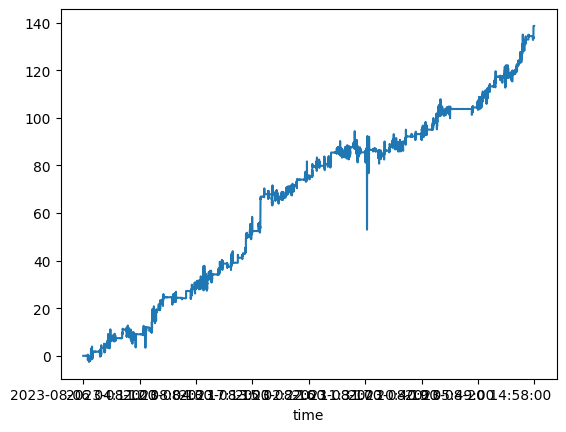

symbols: ['BIFIUSDT', 'YFIUSDT', 'KP3RUSDT']


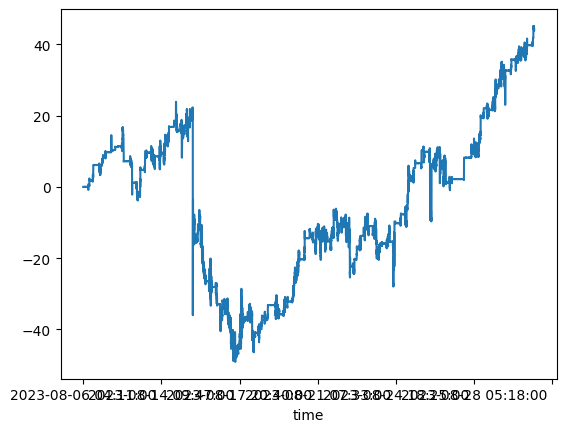

symbols: ['AAVEUSDT', 'BCHUSDT', 'BNBUSDT']


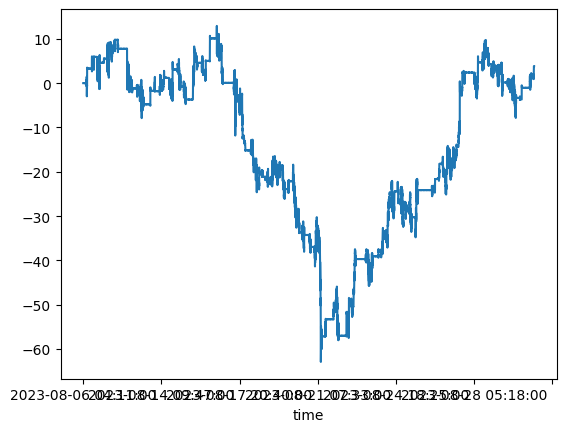

symbols: ['GMXUSDT', 'BTCUSDT', 'MKRUSDT']


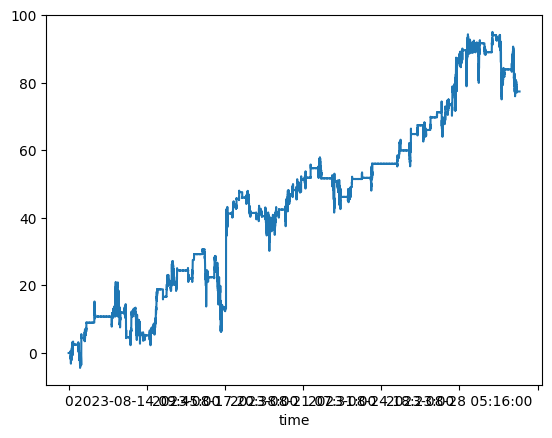

In [33]:
trading_param = TradingParam(60, 2.0)
for symbols in symbols_sets:
    print(f'symbols: {symbols}')
    values_list = get_trading_result(symbols, trading_param)
    values_concat = pd.concat(values_list)
    ax = values_concat.profit_raw.cumsum().plot()
    ymin, ymax = 0, values_concat.profit_raw.cumsum().max()
    
    #ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')
    
    plt.show()

In [35]:
fitting_window, rebalance_period = 180, 180
#df_prices = get_close_between_date(1, symbols, date_str_20220919, date_str_20220922)
df_prices = get_close_between_date(1, symbols, date_str_20230801, date_str_20230831).dropna()
df_rolling_evecs, df_rolling_evecs_resampled = get_var1_wgts_values_transpose_rolling(
    df_prices, window=fitting_window, rebalance_period=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=True)
df_rolling_wgt, df_rolling_wgt_resampled = get_var1_wgts_values_transpose_rolling(
    df_prices, window=fitting_window, rebalance_period=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=False)

In [36]:
df_prices_list = []
head_buffer_length = 60
for i, index_head in enumerate(df_rolling_wgt_resampled.index):
    if i == len(df_rolling_wgt_resampled.index)-1: continue

    index_head_buffered = index_head - pd.Timedelta(minutes=head_buffer_length)
    index_tail = df_rolling_wgt_resampled.index[i+1]
    df_prices_i = df_prices[(df_prices.index < index_tail) & (df_prices.index >= index_head_buffered)]
    df_prices_list.append((index_head_buffered, index_head, index_tail, df_prices_i, df_rolling_wgt_resampled.loc[index_head]))

In [37]:
trading_param = TradingParam(60, 2.0)
values_list = []
for index_head_buffered, index_head, index_tail, df_prices_i, wgt in df_prices_list:
    values_i = add_features(df_prices_i, wgt, trading_param)
    values_i['value_0'] = values_i.value - values_i.value.iloc[0]
    values_list.append(values_i)

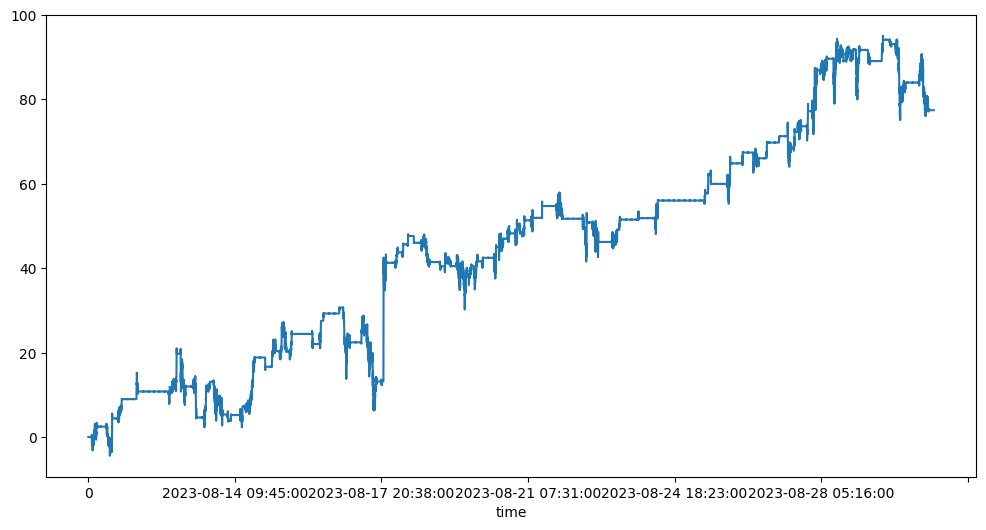

In [38]:
values_concat = pd.concat(values_list)
ax = values_concat.profit_raw.cumsum().plot(figsize=(12, 6))
ymin, ymax = 0, values_concat.profit_raw.cumsum().max()

#ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')

#ax.vlines(x=list(values_concat[values_concat.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
#ax.vlines(x=list(values_concat[values_concat.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

In [377]:
values_list[95][values_list[95].profit_raw > 50]

,value,rebalanced,rebalance_age,upper,lower,value_prev,lower_crossed_upward,lower_crossed_downward,upper_crossed_upward,upper_crossed_downward,in_position,position_changed,mean_size,position_size,profit_raw,profit,value_0
time,,,,,,,,,,,,,,,,,
2023-08-17 21:43:00,225.484735,0,104,205.280144,171.265755,144.899558,1,0,1,0,1,0.0,10819.834398,11486.195017,80.585177,0.556145,27.805852
2023-08-17 21:44:00,301.159549,0,105,232.227344,166.896229,225.484735,0,0,0,0,1,0.0,10480.866355,11486.195017,75.674814,0.335609,103.480666


<Axes: xlabel='time'>

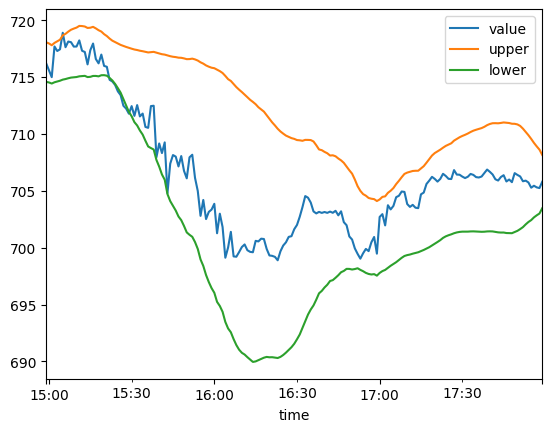

In [679]:
values_list[93][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

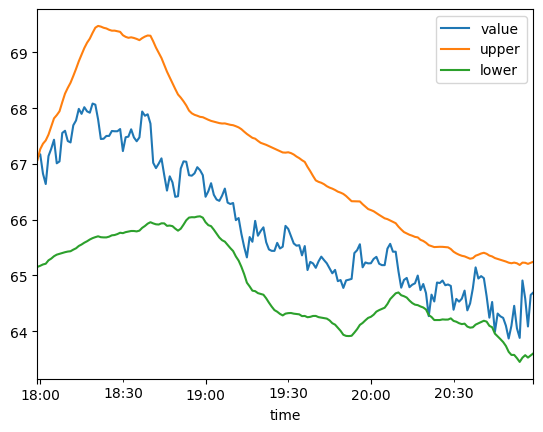

In [680]:
values_list[94][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

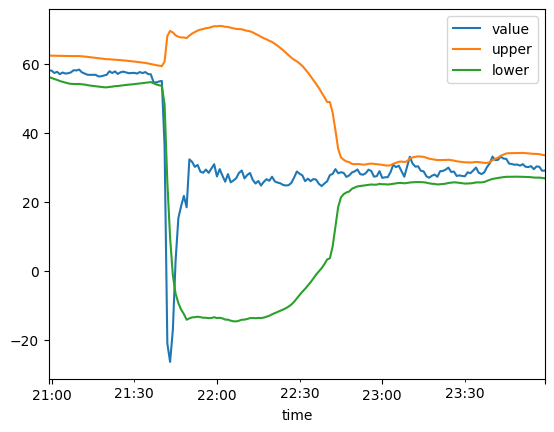

In [681]:
values_list[95][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

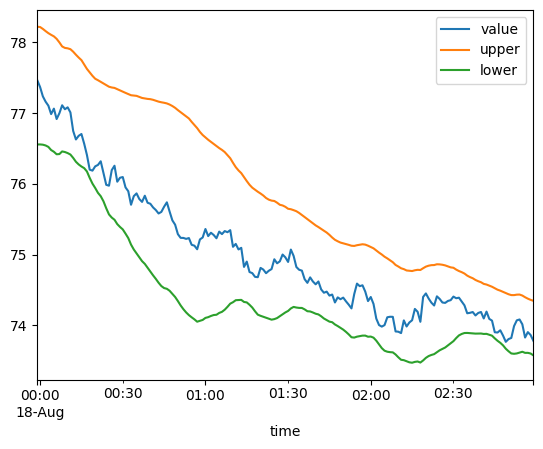

In [682]:
values_list[96][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

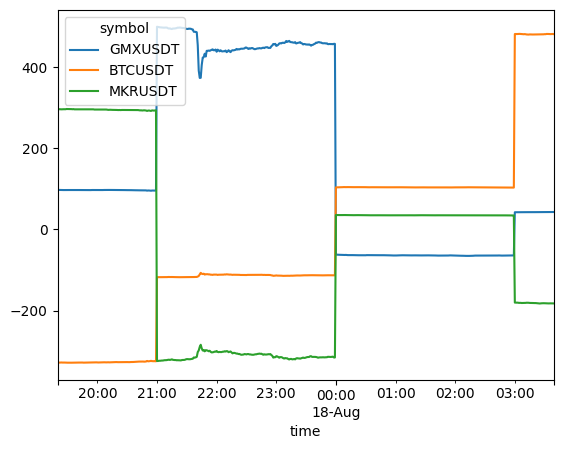

In [683]:
(df_prices * df_rolling_wgt_resampled.resample('1min').first().ffill()).iloc[17000:17500].plot()

<Axes: xlabel='time'>

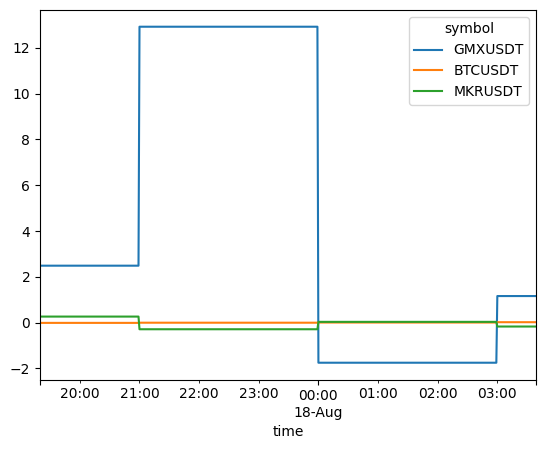

In [684]:
df_rolling_wgt_resampled.resample('1min').first().ffill().iloc[17000:17500].plot()

<Axes: xlabel='time'>

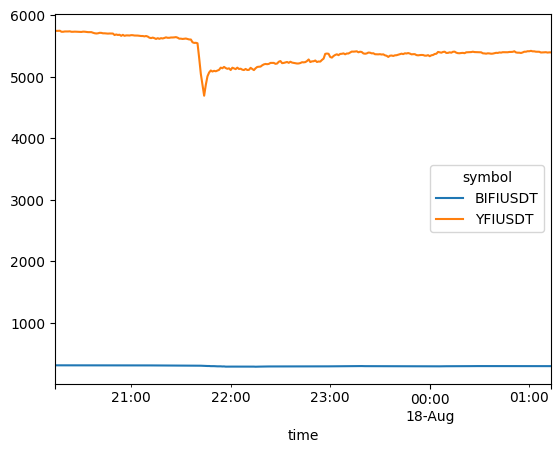

In [660]:
df_prices.iloc[10000:10300].plot()

<Axes: xlabel='time'>

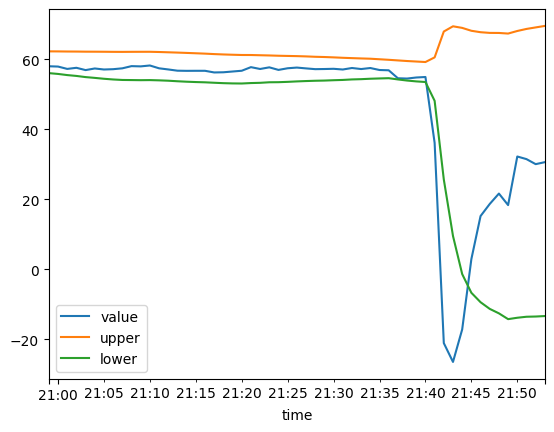

In [607]:
values_list[95].iloc[0:55][['value', 'upper', 'lower']].plot()

In [350]:
values_list[95].iloc[0:10]

,value,rebalanced,rebalance_age,upper,lower,value_prev,lower_crossed_upward,lower_crossed_downward,upper_crossed_upward,upper_crossed_downward,in_position,position_changed,mean_size,position_size,profit_raw,profit,value_0
time,,,,,,,,,,,,,,,,,
2023-08-17 20:59:00,197.678883,0,60,199.556750,196.115248,198.096973,0,0,0,0,0,NaN,11484.300135,0.000000,NaN,NaN,0.000000
2023-08-17 21:00:00,196.827749,0,61,199.455753,196.014269,197.678883,0,0,0,0,0,0.0,11495.700049,0.000000,-0.000000,-0.000000,-0.851134
2023-08-17 21:01:00,195.689635,0,62,199.316355,195.743995,196.827749,0,1,0,0,0,0.0,11498.022285,0.000000,-0.000000,-0.000000,-1.989248
2023-08-17 21:02:00,196.686304,0,63,199.240919,195.650436,195.689635,1,0,0,0,1,1.0,11498.424305,0.000000,0.000000,0.000000,-0.992578
2023-08-17 21:03:00,194.137323,0,64,199.068686,195.160217,196.686304,0,1,0,0,1,0.0,11486.195017,11486.195017,-2.548981,-0.012960,-3.541560
2023-08-17 21:04:00,195.008098,0,65,198.947165,194.860020,194.137323,1,0,0,0,1,0.0,11482.347647,11486.195017,0.870775,0.004485,-2.670785
2023-08-17 21:05:00,195.085826,0,66,198.806383,194.636901,195.008098,0,0,0,0,1,0.0,11488.625791,11486.195017,0.077729,0.000399,-2.593057
2023-08-17 21:06:00,195.145393,0,67,198.694808,194.432955,195.085826,0,0,0,0,1,0.0,11480.122225,11486.195017,0.059566,0.000305,-2.533490
2023-08-17 21:07:00,194.896758,0,68,198.566908,194.227172,195.145393,0,0,0,0,1,0.0,11474.693686,11486.195017,-0.248634,-0.001274,-2.782124


In [344]:
values_list[95].iloc[39:48]

,value,rebalanced,rebalance_age,upper,lower,value_prev,lower_crossed_upward,lower_crossed_downward,upper_crossed_upward,upper_crossed_downward,in_position,position_changed,mean_size,position_size,profit_raw,profit,value_0
time,,,,,,,,,,,,,,,,,
2023-08-17 21:38:00,185.318683,0,99,196.761479,181.625366,185.412153,0,0,0,0,1,0.0,11437.465204,11486.195017,-0.093470,-0.000504,-12.360199
2023-08-17 21:39:00,187.181548,0,100,196.664258,181.320201,185.318683,0,0,0,0,1,0.0,11440.021289,11486.195017,1.862865,0.010052,-10.497335
2023-08-17 21:40:00,187.683243,0,101,196.641494,181.081162,187.181548,0,0,0,0,1,0.0,11438.519034,11486.195017,0.501695,0.002680,-9.995640
2023-08-17 21:41:00,185.229852,0,102,196.515411,180.480934,187.683243,0,0,0,0,1,0.0,11345.714662,11486.195017,-2.453391,-0.013072,-12.449031
2023-08-17 21:42:00,144.899558,0,103,198.955994,169.320459,185.229852,0,1,0,0,1,0.0,11190.363888,11486.195017,-40.330293,-0.217731,-52.779324
2023-08-17 21:43:00,225.484735,0,104,205.280144,171.265755,144.899558,1,0,1,0,1,0.0,10819.834398,11486.195017,80.585177,0.556145,27.805852
2023-08-17 21:44:00,301.159549,0,105,232.227344,166.896229,225.484735,0,0,0,0,1,0.0,10480.866355,11486.195017,75.674814,0.335609,103.480666
2023-08-17 21:45:00,268.614421,0,106,244.281056,168.653239,301.159549,0,0,0,0,1,0.0,10683.840744,11486.195017,-32.545128,-0.108066,70.935539
2023-08-17 21:46:00,242.516953,0,107,249.743334,170.401014,268.614421,0,0,0,1,0,-1.0,10758.113655,11486.195017,-26.097468,-0.097156,44.838070


In [340]:
df_prices.iloc[10085:10100]

symbol,BTCUSDT,BTCBUSD,BNBBUSD
time,,,
2023-08-17 21:38:00,27573.68,27533.57,221.8
2023-08-17 21:39:00,27578.74,27541.68,221.9
2023-08-17 21:40:00,27574.80,27540.52,221.6
2023-08-17 21:41:00,27351.64,27311.28,220.5
2023-08-17 21:42:00,27000.00,26874.42,219.8
2023-08-17 21:43:00,26054.32,26063.61,216.8
2023-08-17 21:44:00,25188.01,25296.86,218.2
2023-08-17 21:45:00,25699.03,25777.76,216.5
2023-08-17 21:46:00,25894.61,25930.44,216.7


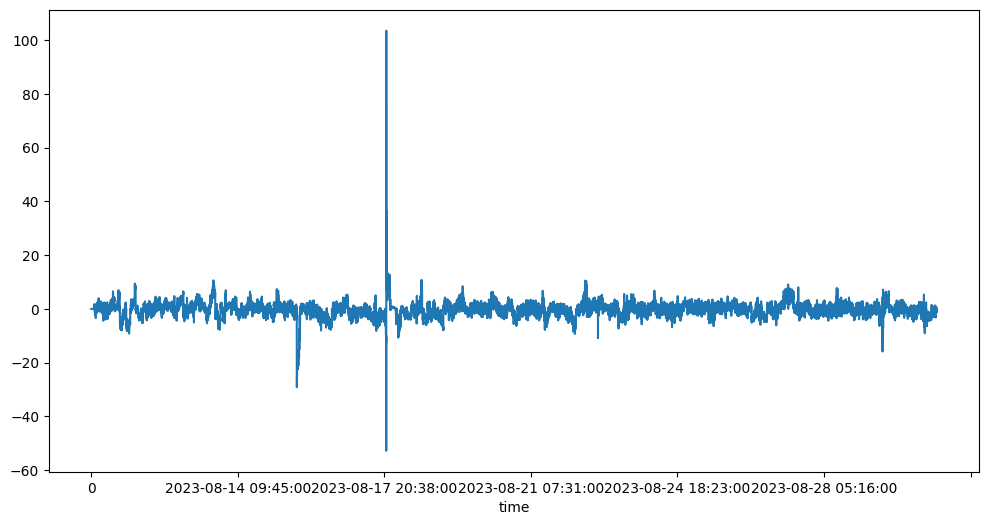

In [413]:
values_concat = pd.concat(values_list)
ax = values_concat.value_0.plot(figsize=(12, 6))
ymin, ymax = values_concat.value_0.min(), values_concat.value_0.max()

#ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')

plt.show()

<Axes: xlabel='time'>

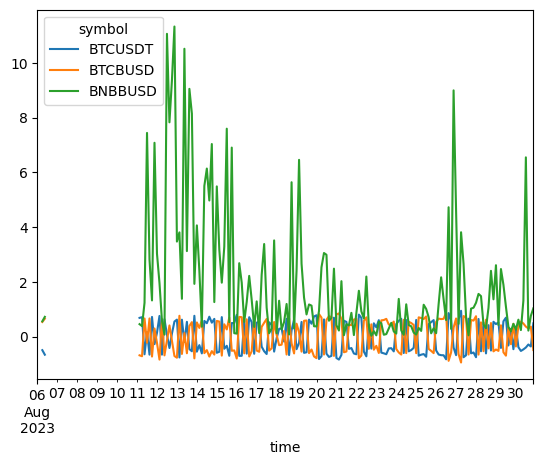

In [266]:
df_rolling_wgt_resampled.plot()

In [259]:
df_rolling_wgt_resampled.index

DatetimeIndex(['2023-08-06 00:00:00', '2023-08-06 03:00:00',
               '2023-08-06 06:00:00', '2023-08-06 09:00:00',
               '2023-08-06 12:00:00', '2023-08-06 15:00:00',
               '2023-08-06 18:00:00', '2023-08-06 21:00:00',
               '2023-08-07 00:00:00', '2023-08-07 03:00:00',
               ...
               '2023-08-29 18:00:00', '2023-08-29 21:00:00',
               '2023-08-30 00:00:00', '2023-08-30 03:00:00',
               '2023-08-30 06:00:00', '2023-08-30 09:00:00',
               '2023-08-30 12:00:00', '2023-08-30 15:00:00',
               '2023-08-30 18:00:00', '2023-08-30 21:00:00'],
              dtype='datetime64[ns]', name='time', length=200, freq='180T')

In [257]:
df_rolling_wgt_resampled

symbol,BTCUSDT,BTCBUSD,BNBBUSD
time,,,
2023-08-06 00:00:00,NaN,NaN,NaN
2023-08-06 03:00:00,NaN,NaN,NaN
2023-08-06 06:00:00,-0.498671,0.531318,0.555894
2023-08-06 09:00:00,-0.664215,0.653163,0.718548
2023-08-06 12:00:00,NaN,NaN,NaN
...,...,...,...
2023-08-30 09:00:00,-0.470847,0.475181,1.309584
2023-08-30 12:00:00,-0.401504,0.361844,6.547826
2023-08-30 15:00:00,-0.291655,0.295036,0.216342


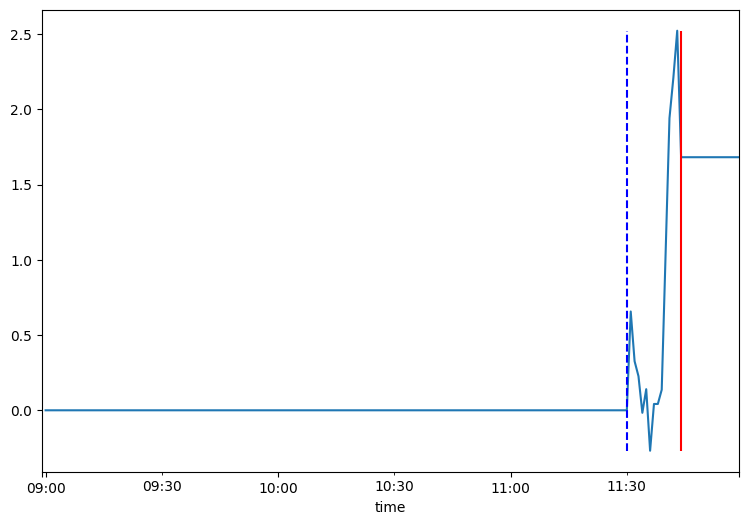

In [414]:
i = len(values_list) // 2
values_i = values_list[i]
ax = values_i.profit_raw.cumsum().plot(figsize=(9, 6))
ymin, ymax = values_i.profit_raw.cumsum().min(), values_i.profit_raw.cumsum().max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

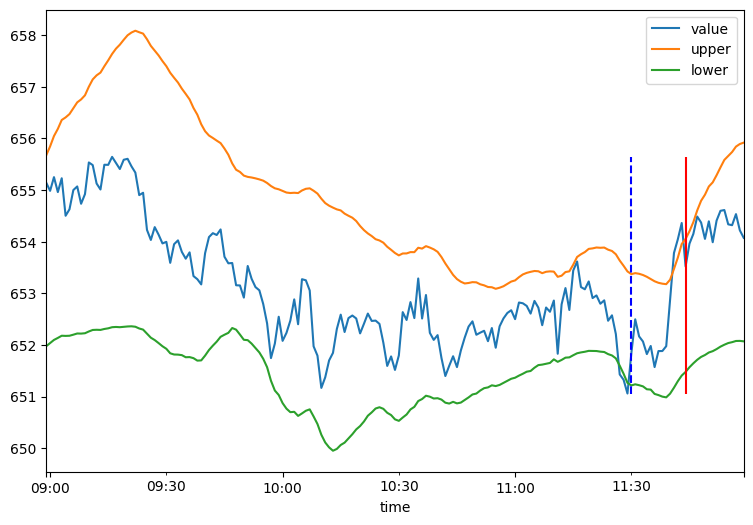

In [415]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_i[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ymin, ymax = values_i.value.min(), values_i.value.max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

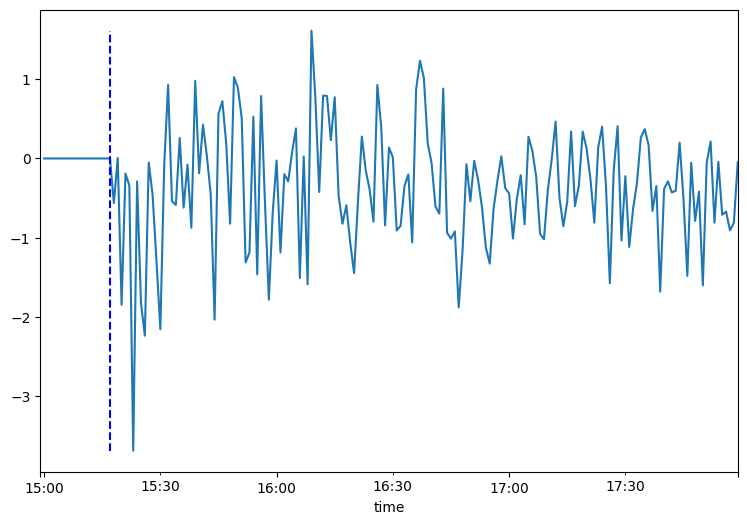

In [253]:
i = -2
values_i = values_list[i]
ax = values_i.profit_raw.cumsum().plot(figsize=(9, 6))
ymin, ymax = values_i.profit_raw.cumsum().min(), values_i.profit_raw.cumsum().max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

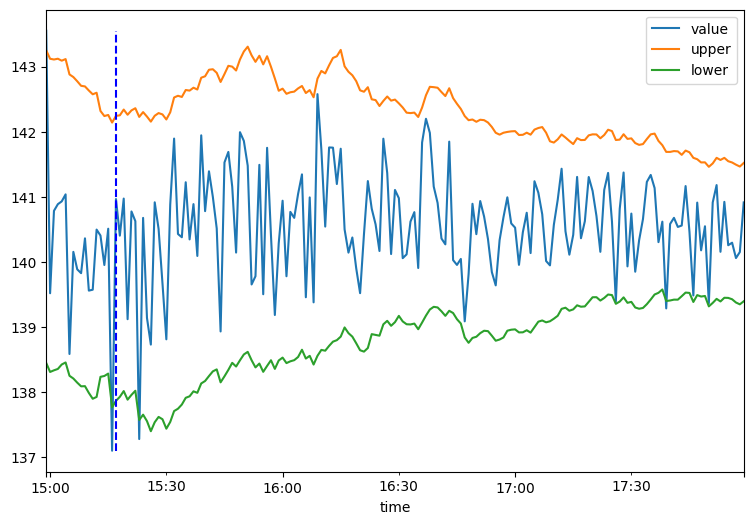

In [254]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_i[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ymin, ymax = values_i.value.min(), values_i.value.max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

<Axes: xlabel='time'>

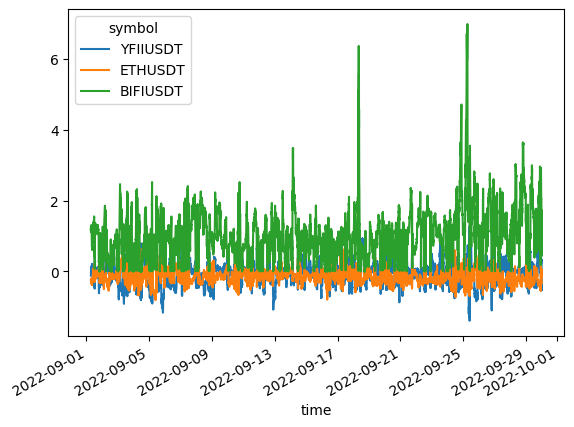

In [75]:
df_rolling_wgt.plot()

<Axes: xlabel='time'>

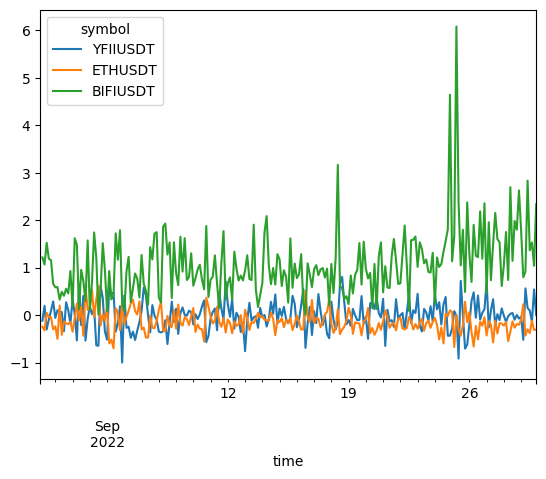

In [76]:
df_rolling_wgt_resampled.plot()